## Brain Tumor Classification using Deep Learning
## Introduction
Brain tumors represent one of the most challenging diagnoses in modern medicine, where early detection and accurate classification can mean the difference between life and death. With over 700,000 people living with primary brain tumors worldwide and approximately 88,970 new cases diagnosed annually in the United States alone, the need for rapid, accurate diagnostic tools has never been more critical.<br>

Traditional brain tumor detection relies heavily on the expertise of radiologists who manually analyze Magnetic Resonance Imaging (MRI) scans—a process that is not only time-intensive but also subject to human variability and potential oversight. Studies have shown that diagnostic accuracy can vary significantly between practitioners, with interpretation differences occurring in up to 20% of cases. This variability, combined with the growing shortage of specialized radiologists and the increasing volume of imaging studies, creates a compelling case for automated diagnostic assistance.
Recent advances in deep learning, particularly Convolutional Neural Networks (CNNs), have demonstrated remarkable success in medical image analysis, often achieving diagnostic accuracy comparable to or exceeding that of expert clinicians. These models excel at detecting subtle patterns and features in medical images that might be imperceptible to the human eye, making them invaluable tools for augmenting clinical decision-making.

## Project Objectives
This project aims to develop a deep learning model using PyTorch that can automatically classify brain MRI images as either containing a tumor or being tumor-free. Our specific objectives is;
<br>
**Binary Classification Performance:** Achieve high accuracy in distinguishing between tumor-positive and tumor-negative brain MRI scans

## Dataset Overview
The dataset used for this project is the "Brain MRI Images for Brain Tumor Detection", originally published on [Kaggle](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/data). It consists of a collection of brain MRI scans, organized into two distinct categories: images with brain tumors and images without brain tumors.The images are stored in a folder-based format where each subdirectory represents a class label. Specifically, the dataset is divided into two folders: yes/, containing images of brains with visible tumors, and no/, containing scans without tumors. In total, the dataset contains 253 images, which are unevenly distributed between the two classes.

All images are MRI scans, originally in grayscale, but they are loaded as RGB images to match the input requirements of the model architecture. To ensure consistency and compatibility across the dataset, all images are resized to a fixed resolution of 128×128 pixels. For the training set, additional data augmentation is applied to improve generalization and reduce overfitting. Specifically, a small amount of brightness and contrast variation is introduced using ColorJitter. Following augmentation, all images are converted to tensors and normalized using ImageNet mean and standard deviation values (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), which is a common convention for CNN-based image classification.

The dataset was split using a 80-10-10 ratio for training, validation, and testing respectively. This ensures that the model has sufficient data for learning while also maintaining fair evaluation through unseen examples. To ensure reproducibility, a random seed is used during the split process.


In [10]:
#Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchmetrics.classification import F1Score, Precision, Recall, Accuracy, BinaryConfusionMatrix

import os
from PIL import Image

No tumor images: 98
Yes tumor images: 155


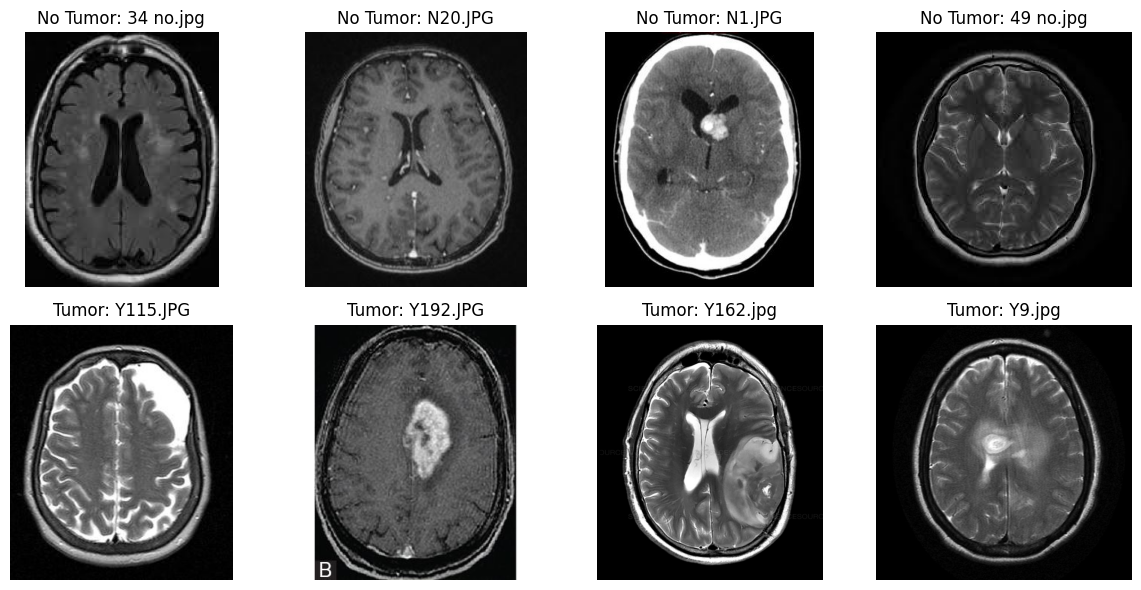

In [2]:
base_path = "/kaggle/input/brain-mri-images-for-brain-tumor-detection"
no_tumor = os.path.join(base_path, "no")
yes_tumor = os.path.join(base_path, "yes")

print(f"No tumor images: {len(os.listdir(no_tumor))}")
print(f"Yes tumor images: {len(os.listdir(yes_tumor))}")

# Look at a few sample images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Sample from 'no' folder
no_files = os.listdir(no_tumor)[:4]
for i, filename in enumerate(no_files):
    img = Image.open(os.path.join(no_tumor, filename))
    axes[0, i].imshow(img, cmap='gray' if img.mode == 'L' else None)
    axes[0, i].set_title(f'No Tumor: {filename}')
    axes[0, i].axis('off')

# Sample from 'yes' folder
yes_files = os.listdir(yes_tumor)[:4]
for i, filename in enumerate(yes_files):
    img = Image.open(os.path.join(yes_tumor, filename))
    axes[1, i].imshow(img, cmap='gray' if img.mode == 'L' else None)
    axes[1, i].set_title(f'Tumor: {filename}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [3]:
#base_path = "/kaggle/input/brain-mri-images-for-brain-tumor-detection"
base_path ="/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset"

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ColorJitter(brightness=0.05, contrast=0.05),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

full_dataset = ImageFolder(root=base_path)
tot_size = len(full_dataset)
train_size = int(0.8 * tot_size)
val_size = int(0.1 * tot_size)
test_size = tot_size - train_size - val_size


generator = torch.Generator().manual_seed(42)
train_indices, val_indices, test_indices = random_split(
    range(tot_size), 
    [train_size, val_size, test_size], 
    generator=generator
)

train_dataset_aug = ImageFolder(base_path, transform=train_transform)
val_dataset_clean = ImageFolder(base_path, transform=val_test_transform)
test_dataset_clean = ImageFolder(base_path, transform=val_test_transform)

# Apply the indices to get non-overlapping subsets
train_dataset = Subset(train_dataset_aug, train_indices)
val_dataset = Subset(val_dataset_clean, val_indices)  
test_dataset = Subset(test_dataset_clean, test_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
from collections import Counter

def get_class_distribution(dataset):
    labels = [label for _, label in dataset]
    return dict(Counter(labels))

print("Train distribution:", get_class_distribution(train_dataset))
print("Validation distribution:", get_class_distribution(val_dataset))
print("Test distribution:", get_class_distribution(test_dataset))

Train distribution: {0: 82, 1: 120}
Validation distribution: {1: 17, 0: 8}
Test distribution: {1: 18, 0: 8}


In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
        )
        self.classifier1 = nn.Linear(64*32*32, 128)
        self.classifier2 = nn.Linear(128, 1)

    def forward(self, x):
        x=self.feature_extractor(x)
        x=self.classifier1(x)
        x=nn.functional.relu(x)
        x=self.classifier2(x)
        return x

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Net().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Binary classification metrics
train_precision = Precision(task="binary").to(device)
train_recall = Recall(task="binary").to(device)
train_f1 = F1Score(task="binary").to(device)
train_accuracy = Accuracy(task="binary").to(device)

val_precision = Precision(task="binary").to(device)
val_recall = Recall(task="binary").to(device)
val_f1 = F1Score(task="binary").to(device)
val_accuracy = Accuracy(task="binary").to(device)

confusion_matrix = BinaryConfusionMatrix().to(device)
# Training loop
num_epochs = 10
best_val_f1 = 0.0

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # Ensure labels are float for BCEWithLogitsLoss
        labels = labels.float()
        
        optimizer.zero_grad()
        outputs = model(inputs)
        # For binary classification, outputs should be shape [batch_size, 1] or [batch_size]
        if outputs.dim() > 1 and outputs.size(1) == 1:
            outputs = outputs.squeeze(1)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Convert logits to probabilities for metrics
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()
        
        train_accuracy.update(preds, labels)
        train_precision.update(preds, labels)
        train_recall.update(preds, labels)
        train_f1.update(preds, labels)
    
    # Compute training metrics
    train_acc = train_accuracy.compute()
    train_prec = train_precision.compute()
    train_rec = train_recall.compute()
    train_f1_score = train_f1.compute()
    
    # Reset training metrics
    train_accuracy.reset()
    train_precision.reset()
    train_recall.reset()
    train_f1.reset()
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float()
            
            outputs = model(inputs)
            if outputs.dim() > 1 and outputs.size(1) == 1:
                outputs = outputs.squeeze(1)
            
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # Convert logits to probabilities for metrics
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            
            val_accuracy.update(preds, labels)
            val_precision.update(preds, labels)
            val_recall.update(preds, labels)
            val_f1.update(preds, labels)
    
    # Compute validation metrics
    val_acc = val_accuracy.compute()
    val_prec = val_precision.compute()
    val_rec = val_recall.compute()
    val_f1_score = val_f1.compute()
    
    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}, "
          f"Train Prec: {train_prec:.4f}, Train Rec: {train_rec:.4f}, Train F1: {train_f1_score:.4f}")
    print(f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.4f}, "
          f"Val Prec: {val_prec:.4f}, Val Rec: {val_rec:.4f}, Val F1: {val_f1_score:.4f}")
    print("-" * 80)
    
    # Save best model based on validation F1 score
    if val_f1_score > best_val_f1:
        best_val_f1 = val_f1_score
        torch.save(model.state_dict(), 'best_brain_tumor_model.pth')
        print(f"New best model saved with Val F1: {best_val_f1:.4f}")
    
    # Reset validation metrics
    val_accuracy.reset()
    val_precision.reset()
    val_recall.reset()
    val_f1.reset()

Epoch 1/10
Train Loss: 2.7973, Train Acc: 0.6139, Train Prec: 0.6909, Train Rec: 0.6333, Train F1: 0.6609
Val Loss: 3.7110, Val Acc: 0.6800, Val Prec: 0.6957, Val Rec: 0.9412, Val F1: 0.8000
--------------------------------------------------------------------------------
New best model saved with Val F1: 0.8000
Epoch 2/10
Train Loss: 2.1346, Train Acc: 0.6485, Train Prec: 0.6960, Train Rec: 0.7250, Train F1: 0.7102
Val Loss: 1.0140, Val Acc: 0.6000, Val Prec: 0.7692, Val Rec: 0.5882, Val F1: 0.6667
--------------------------------------------------------------------------------
Epoch 3/10
Train Loss: 0.4530, Train Acc: 0.7426, Train Prec: 0.8542, Train Rec: 0.6833, Train F1: 0.7593
Val Loss: 0.5945, Val Acc: 0.7600, Val Prec: 0.7619, Val Rec: 0.9412, Val F1: 0.8421
--------------------------------------------------------------------------------
New best model saved with Val F1: 0.8421
Epoch 4/10
Train Loss: 0.4179, Train Acc: 0.8267, Train Prec: 0.8102, Train Rec: 0.9250, Train F1: 0.8

In [11]:
print("\nTesting on test set...")
model.load_state_dict(torch.load('best_brain_tumor_model.pth'))
model.eval()

test_precision = Precision(task="binary").to(device)
test_recall = Recall(task="binary").to(device)
test_f1 = F1Score(task="binary").to(device)
test_accuracy = Accuracy(task="binary").to(device)
test_loss = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.float()
        
        outputs = model(inputs)
        if outputs.dim() > 1 and outputs.size(1) == 1:
            outputs = outputs.squeeze(1)
        
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        # Convert logits to probabilities for metrics
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()
        
        test_accuracy.update(preds, labels)
        test_precision.update(preds, labels)
        test_recall.update(preds, labels)
        test_f1.update(preds, labels)
        confusion_matrix.update(preds, labels)


# Compute final test metrics
test_acc = test_accuracy.compute()
test_prec = test_precision.compute()
test_rec = test_recall.compute()
test_f1_score = test_f1.compute()
cm = confusion_matrix.compute()

print(f"\nFinal Test Results:")
print(f"Test Loss: {test_loss/len(test_loader):.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")
print(f"Test F1 Score: {test_f1_score:.4f}")


Testing on test set...

Final Test Results:
Test Loss: 0.6161
Test Accuracy: 0.7692
Test Precision: 0.9286
Test Recall: 0.7222
Test F1 Score: 0.8125


In [ ]:


with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.float()
        
        outputs = model(inputs)
        if outputs.dim() > 1 and outputs.size(1) == 1:
            outputs = outputs.squeeze(1)
        
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()
        confusion_matrix.update(preds, labels)

cm = confusion_matrix.compute()
print(f"\nConfusion Matrix:")
print(f"TN: {cm[0,0]}, FP: {cm[0,1]}")
print(f"FN: {cm[1,0]}, TP: {cm[1,1]}")

In [12]:
def plot_confusion_matrix(cm_tensor):
    cm = cm_tensor.cpu().numpy()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Tumor', 'Tumor'], 
                yticklabels=['No Tumor', 'Tumor'])
    
    plt.title('Brain Tumor Classsification - Confusion Matrix', fontsize=16, pad=20)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    
    plt.tight_layout()
    plt.show()

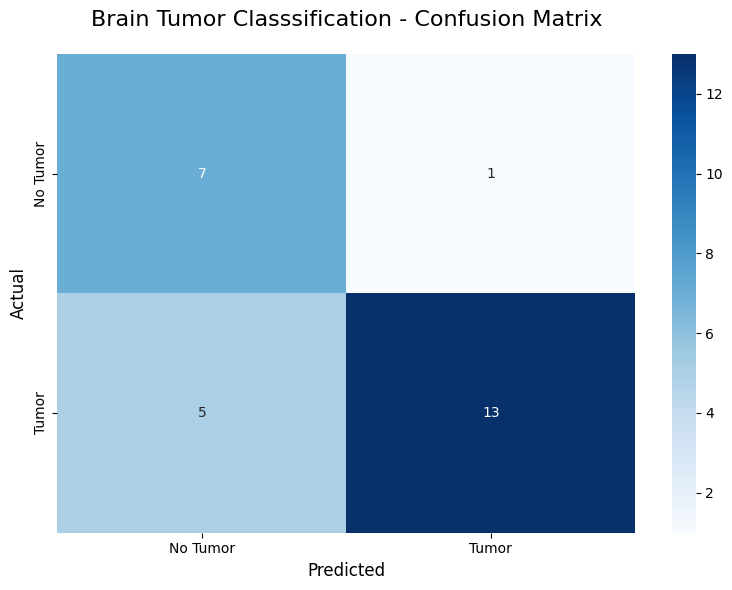

In [13]:
plot_confusion_matrix(cm)

*Note: This project was undertaken by me in the process of taking ML Scientist track on Datacamp to help me solidify my learnings.*